In [209]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import SGD, Adam
from torchvision  import transforms
from PIL import Image
import numpy as np
from torchvision.models import inception_v3

import os
import matplotlib.pyplot as plt

## Data available is very low, so once solution is transfer learning
- Going to use Inception Network

In [4]:
!ls

LICENSE                                Urban-Rural-Scene-classification.ipynb
README.md                              urban-rural-data


#### remember:
- We are creating a transformation pipeline.
- While training with many epoch, on each epoch we get different transformation of same image because of augmentation. 
- We are no where  creating new dataset, rather just apply transformation while training.

In [62]:
transform_train = transforms.Compose([
                                transforms.Resize([342], interpolation=transforms.InterpolationMode.BILINEAR),
                                transforms.CenterCrop([299,299]),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.ToTensor(), # Rescaled to 0-1 aswell
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Mean and std of imageNet
])

transform = transforms.Compose([
                                transforms.Resize([342], interpolation=transforms.InterpolationMode.BILINEAR),
                                transforms.CenterCrop([299,299]),
                                transforms.ToTensor() # # Rescaled to 0-1 aswell
])

In [63]:
class CustomData(Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.transform = transform
        directories = ['rural', 'urban']
        self.files = []
        self.labels = []
        for i, subdir in enumerate(directories):
            subpath = os.path.join(path, subdir)
            files = os.listdir(subpath)
            length = len(files)
            if '.DS_Store' in files:
                files.remove('.DS_Store')
            for j in range(length):
                files[j] = os.path.join(subpath, files[j])
            self.files.extend(files)
            self.labels.extend([i] * length)
            
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        file = self.files[index]
        image = Image.open(file)
        image = self.transform(image)
        return image, self.labels[index]

In [65]:
train_dataset = CustomData(path = 'urban-rural-data/train/', transform=transform_train)
valid_dataset = CustomData(path='urban-rural-data/val/', transform=transform)

##### Train data size

In [79]:
len(train_dataset)

72

##### Validation data size

In [70]:
len(valid_dataset)

20

In [72]:
torch.manual_seed(1)
data = DataLoader(train_dataset, 32, shuffle=True)
data_vl = DataLoader(valid_dataset, 4, shuffle=True)

##### Load pretrained model

In [77]:
model = inception_v3(weights="IMAGENET1K_V1")

In [78]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

##### Freeze all layers from training

In [81]:
for param in model.parameters():
    param.requires_grad = False

##### Note:
- In Inception Architecture outputs are derived from two units
    - auxilary unit
    - Main output unit
- So since we are doing binary classification, we have to change output size of both units

In [141]:
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 1)

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)

##### Now:
- Now final layer returns only one output probability.
    - if 1 then urban
    - else rural

In [142]:
model 

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

##### Store all layers for which alone training should be done. 
- As we have added new  FC layers to both units(Auxilary and normal output unit), by default, they keep track of gradients. hence we can add parameters (weights and biases) of those layers to `params_to_update`

In [143]:
params_to_update = []
# As we have 
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(param.shape)
        print("\t",name)

torch.Size([1, 768])
	 AuxLogits.fc.weight
torch.Size([1])
	 AuxLogits.fc.bias
torch.Size([1, 2048])
	 fc.weight
torch.Size([1])
	 fc.bias


In [144]:
loss_fn = nn.BCEWithLogitsLoss() 
optimizer = Adam(params_to_update, lr=0.001)

##### Train loop
- Train loop to feed 72 train data to model's final layer and finetune it.
    - If performance doesn't seems to good, then further previous layers have to be changed
- At each epoch, validation performance is also evaluated

In [145]:
def train(model, epoch, data, data_vl):
    train_loss = [0] * epoch
    train_accuracy = [0] * epoch
    valid_loss = [0] * epoch
    valid_accuracy = [0] * epoch
    for i in range(epoch):
        model.train()
        for x_batch, y_batch in data:
            x_batch = x_batch.to(torch.float32)
            y_batch = y_batch.to(torch.float32)
            pred, _ = model(x_batch) # No need to keep track of auxilary output, pred-> logits
            pred = pred.reshape(-1).to(torch.float32)
#             print(pred.dtype, y_batch.dtype)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
             # loss.item is average over batch values. Multiplying with batch size give sum of errors. which we can finally take whole epoch average
            train_loss[i] += loss.item() * x_batch.size(0)
            correct = torch.sum((pred>=0.5) == y_batch)
#             print(correct)
            train_accuracy[i] += correct.to(torch.float32).item()
        
#         print(train_accuracy, train_loss)
        train_loss[i] /= len(data.dataset)
        train_accuracy[i] /= len(data.dataset)
        
        # As I have enables evaluation mode, I auxilary output won't be calculated.
        model.eval() 
        with torch.no_grad():
            for x_batch, y_batch in data_vl:
                x_batch = x_batch.to(torch.float32)
                y_batch = y_batch.to(torch.float32)
                pred = model(x_batch) # No need to keep track of auxilary output, pred-> logits
                pred = pred.reshape(-1).to(torch.float32)
                loss = loss_fn(pred, y_batch)
                valid_loss[i] += loss.item() * x_batch.size(0)
                correct = torch.sum((pred>=0.5) == y_batch)
                valid_accuracy[i] += correct.to(torch.float32).item()

            valid_loss[i] /= len(data_vl.dataset)
            valid_accuracy[i] /= len(data_vl.dataset)
        print(f'Epoch {i+1} accuracy: {train_accuracy[i]:.4f} val_accuracy:{valid_accuracy[i]:.4f}')
        print(f'Epoch {i+1} loss: {train_loss[i]:.4f} val_loss:{valid_loss[i]:.4f}')
        print()
            

In [146]:
train(model, 30, data, data_vl)

Epoch 1 accuracy: 0.4861 val_accuracy:0.5000
Epoch 1 loss: 0.7071 val_loss:0.6668

Epoch 2 accuracy: 0.5972 val_accuracy:0.5000
Epoch 2 loss: 0.6221 val_loss:0.6243

Epoch 3 accuracy: 0.5278 val_accuracy:0.5000
Epoch 3 loss: 0.6126 val_loss:0.5963

Epoch 4 accuracy: 0.5139 val_accuracy:0.5000
Epoch 4 loss: 0.5599 val_loss:0.5826

Epoch 5 accuracy: 0.5278 val_accuracy:0.5500
Epoch 5 loss: 0.5450 val_loss:0.5379

Epoch 6 accuracy: 0.7500 val_accuracy:0.7000
Epoch 6 loss: 0.4772 val_loss:0.5064

Epoch 7 accuracy: 0.8472 val_accuracy:0.8500
Epoch 7 loss: 0.4690 val_loss:0.4831

Epoch 8 accuracy: 0.9167 val_accuracy:0.9000
Epoch 8 loss: 0.4389 val_loss:0.4646

Epoch 9 accuracy: 0.9306 val_accuracy:0.7500
Epoch 9 loss: 0.4176 val_loss:0.4440

Epoch 10 accuracy: 0.9028 val_accuracy:0.7500
Epoch 10 loss: 0.3985 val_loss:0.4273

Epoch 11 accuracy: 0.9444 val_accuracy:0.7500
Epoch 11 loss: 0.3647 val_loss:0.4092

Epoch 12 accuracy: 0.9583 val_accuracy:0.8000
Epoch 12 loss: 0.3607 val_loss:0.3867

###### Seems like overfitting???? 
😱
#### Due to unavailibility of data, I used all data for training and validation. In order to test the performance I have to randomly pick urban/rural area pictures from internet. lets see whether our model is overfitter, or it is any good!!

In [147]:
!ls

LICENSE                                test_data
README.md                              urban-rural-data
Urban-Rural-Scene-classification.ipynb


In [152]:
test_files = os.listdir('test_data')
if '.DS_Store' in test_files:
    test_files.remove('.DS_Store')

##### I have downloaded the images from [pexels.com](https://www.pexels.com/)
- Lets visualise them
- rural is class 0, urban is class 1

In [167]:
test_dataset = CustomData(path='test_data', transform=transform)

In [178]:
len(test_dataset)

6

In [193]:
data_test = DataLoader(test_dataset, batch_size=1)

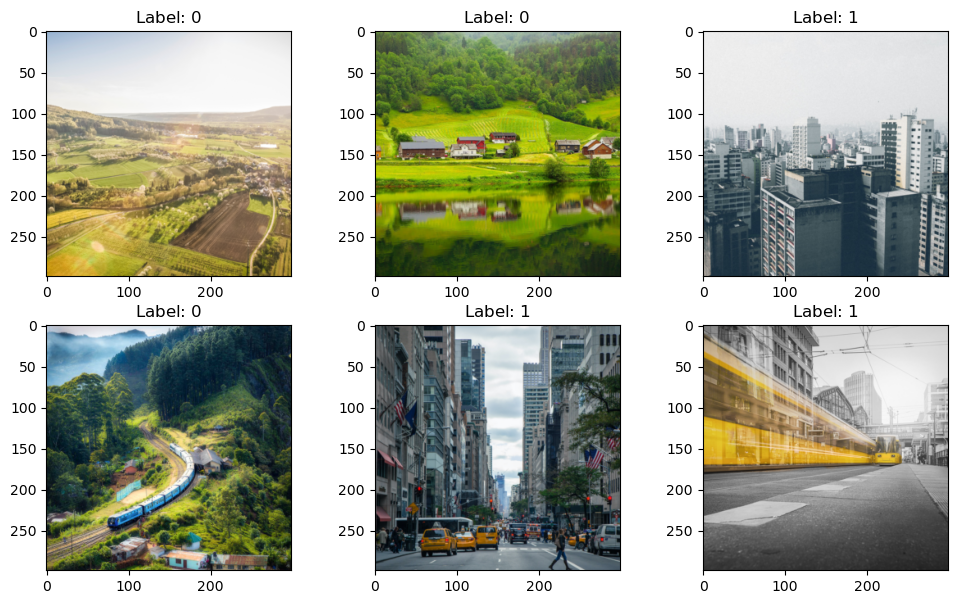

In [219]:
plt.figure(figsize=(12,7))
for i, data in enumerate(data_test):
    plt.subplot(2,3,i+1)
    x,y = data
    x = x.squeeze(0)
    x = x.permute(1,2,0)
    plt.title(f'Label: ${y.item()}$')
    plt.imshow(x)
plt.show()

##### Lets check out models performance


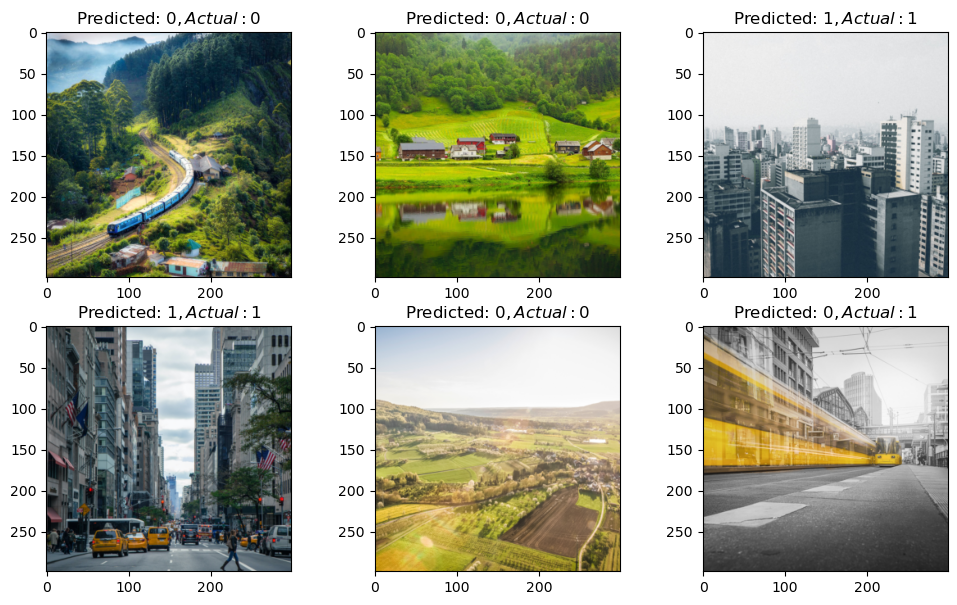

In [220]:
model.eval()
with torch.no_grad():
    plt.figure(figsize=(12,7))
    for i, data in enumerate(data_test):
        plt.subplot(2,3,i+1)
        x,y = data
        x = x.to(torch.float32)
        pred = model(x)
        pred = torch.where(pred>=0.5, 1, 0).item()
        x = x.squeeze(0)
        x = x.permute(1,2,0)
        plt.title(f'Predicted: ${pred}, Actual: {y.item()} $')
        plt.imshow(x)
    plt.show()   
    

##### Not bad, so our model predicts well

### To save model

In [238]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'inception_finetuned_model.pt')

##### Load and check

In [239]:
checkpoint = torch.load('inception_finetuned_model.pt')

In [236]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [237]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri